# Electric Vehicle (EV) Efficiency Research

Being able to predict the operating parameters of an electric vehicle motor is an important emerging task due to the huge demand of electric vehicles in todays society.

Throughout this notebook, we'll take the measured parameters of a Permanent-Magnet Synchronous Motor (PMSM) and attempt to predict all four output temperatures (permanent magnetic, stator yoke, stator winding and stator tooth) as accurately as possible. This forms an interesting multi-output regression task, and we'll explore various feature engineering, models and hyper-parameter tuning accordingly.

Main questions / points for future improvement:

- Is it better to train four distinct models for each output temperature variable, or a single unified model that outputs all four variables for the given input variables?


- What are the units / form of the input features provided in the motor dataset? This is needed for feature engineering the given data into more useful electrical terms, e.g. apparent power. Can we work out these terms with the standardised features in their current form?


- What is the benefits of applying a low-pass filter to the data (i.e. an Exponentially Weighted Moving Average and Standard Deviation equivalent).


- Can we make use of data over time for this competition, or does it have to only use the current timestep data? This is important if we want to make use of lagged features and time data for preprocessing steps such as low-pass filters.


- Will filtering the output predictions from the regression model improve the performance? This depends on us being able to apply time-dependent functions to our data, i.e. filtering.


TO-DO:

-  Make a baseline model using only the initial dataset (unaltered), to gauge how well we should be doing.


- Investigate the performance improvements gained from using dimensionality reduction techniques on our data.


- Improve training / validation split by using unique profile IDs within each.

## 1. Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_validate

from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR, LinearSVR

from tqdm import tqdm

## 2. Import our dataset train and test splits

In [2]:
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')
train_df.shape, test_df.shape

((846368, 13), (76423, 8))

In [3]:
train_df.index.name = 'timestep'
test_df.index.name = 'timestep'

In [4]:
train_df.shape, test_df.shape

((846368, 13), (76423, 8))

In [5]:
train_df.head(3)

ambient   coolant       u_d       u_q  motor_speed    torque  \
timestep                                                                  
0        -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182   
1        -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133   
2        -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431   

               i_d       i_q        pm  stator_yoke  stator_tooth  \
timestep                                                            
0         1.029572 -0.245860 -2.522071    -1.831422     -2.066143   
1         1.029509 -0.245832 -2.522418    -1.830969     -2.064859   
2         1.029448 -0.245818 -2.522673    -1.830400     -2.064073   

          stator_winding  profile_id  
timestep                              
0              -2.018033           4  
1              -2.017631           4  
2              -2.017343           4

In [6]:
test_df.head(3)

ambient   coolant       u_d       u_q  motor_speed    torque  \
timestep                                                                  
0        -2.749564 -1.073478  0.336463 -1.295874    -1.222426 -0.248547   
1        -2.749612 -1.072823  0.339015 -1.298281    -1.222425 -0.247740   
2        -2.746339 -1.073277  0.340775 -1.299160    -1.222428 -0.247232   

               i_d       i_q  
timestep                      
0         1.041590 -0.250223  
1         1.038055 -0.248936  
2         1.035532 -0.248042

## 3. Initial Exploratory Data Analysis

### 3.1 General trends of our data features

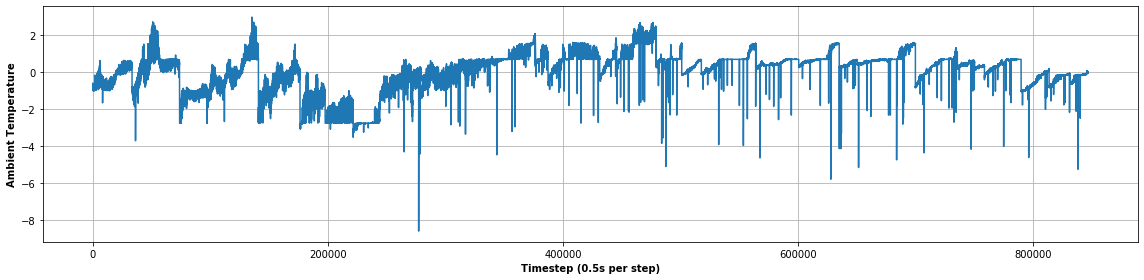

In [7]:
train_df.loc[:, 'ambient'].plot(figsize=(16,4))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

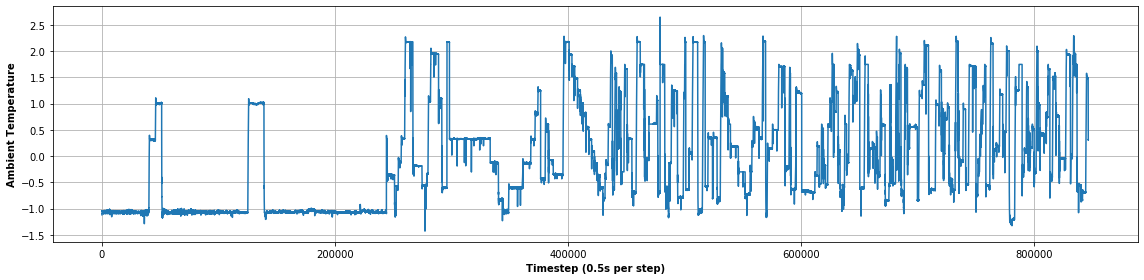

In [8]:
train_df.loc[:, 'coolant'].plot(figsize=(16,4))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

Our training data appears to be ordered and not shuffled, as can be seen from the relatively continuous series represented above for the two selected variables.

In [9]:
train_df.describe()

ambient        coolant            u_d            u_q  \
count  846368.000000  846368.000000  846368.000000  846368.000000   
mean        0.082853       0.027152       0.052589       0.003834   
std         0.977933       1.016069       0.996975       0.999539   
min        -8.573954      -1.429349      -1.655373      -1.861463   
25%        -0.345336      -1.040140      -0.787199      -0.916409   
50%         0.339621      -0.139105       0.292743      -0.085806   
75%         0.688248       0.717035       0.404600       0.844942   
max         2.967117       2.649032       2.274734       1.793498   

         motor_speed         torque            i_d            i_q  \
count  846368.000000  846368.000000  846368.000000  846368.000000   
mean       -0.010858      -0.041547       0.026560      -0.040897   
std         1.000756       1.000715       0.987589       1.000951   
min        -1.239020      -3.345953      -3.245874      -3.341639   
25%        -0.951889      -0.365100      -0.750257      -0.362148   
50%        -0.140247      -0.237407       0.254701      -0.245697   
75%         0.844814       0.472951       1.013977       0.486917   
max         2.024164       3.016971       1.060937       2.914185   

                  pm    stator_yoke   stator_tooth  stator_winding  \
count  846368.000000  846368.000000  846368.000000   846368.000000   
mean       -0.000441       0.012695       0.000753       -0.008259   
std         0.991628       1.015148       1.006694        0.997647   
min        -2.628648      -1.834688      -2.066143       -2.019973   
25%        -0.656185      -0.736750      -0.761951       -0.723910   
50%         0.083156      -0.052310       0.012339        0.009469   
75%         0.684179       0.728644       0.778085        0.707115   
max         2.917456       2.449158       2.302169        2.653781   

          profile_id  
count  846368.000000  
mean       50.608782  
std        23.079908  
min         4.000000  
25%        30.000000  
50%        56.000000  
75%        68.000000  
max        81.000000

The features within the data appears to have already been standardised with a zero mean and standard deviation of 1. This is unfortunate, since it makes manipulation of the electrical parameters and measured values into more useful and insightful ones a more difficult task.

In [10]:
train_df['profile_id'].value_counts()[:5]

20    43970
6     40387
65    40093
66    36475
27    35360
Name: profile_id, dtype: int64

### 3.2 Exploring trends within an example Profile ID

**Lets briefly explore the data associated with an example profile ID**

In [11]:
EXAMPLE_ID = 10

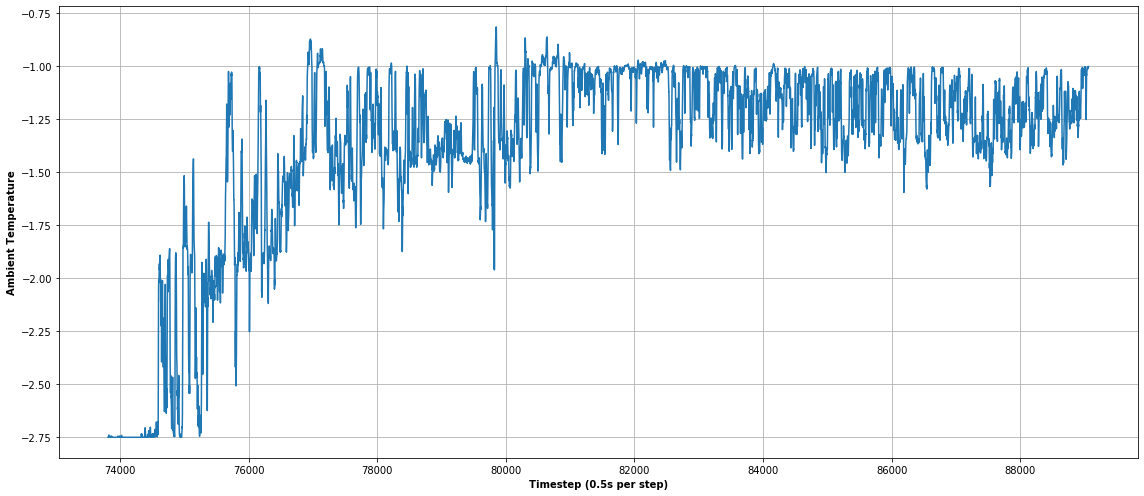

In [12]:
example_profile = train_df.loc[train_df['profile_id'] == EXAMPLE_ID].copy()
example_profile['ambient'].plot(figsize=(16,7))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

This data is extremely noisy in its current form, which could be detrimental to our results for making temperature predictions. To overcome this, we could consider pre-processing strategies such as applying filters over the data to smooth it. A good strategy for this could be to apply one or more low-pass filters to the data. A good means of achieving this could be to apply an exponentially weighted moving average and standard deviation to each of our features, especially those that are particularly noisy.

In [13]:
# choose a range of spans to experiment with
spans = [600, 1200, 2400, 4800]

for span in spans:
    new_col = f"ambient_exp_{span}"
    example_exp_ma = example_profile.ewm(span=span, adjust=False).mean()
    example_profile[new_col] = example_exp_ma['ambient'].copy()
    
ambient_cols = [x for x in example_profile.columns.values if x.startswith('ambient')]

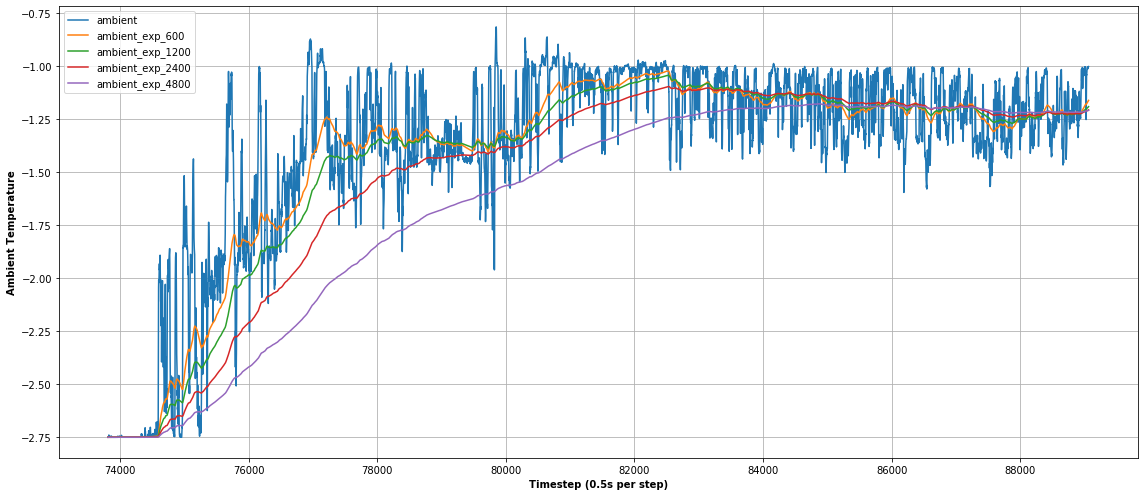

In [14]:
example_profile[ambient_cols].plot(figsize=(16,7))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

By applying exponential weighted moving average functions as shown above, we can effectively reduce the noise within our dataset, which will hopefully help improve the performance of our models.

In [15]:
# choose a range of spans to experiment with
spans = [600, 1200, 2400]

chosen_col = 'coolant'

for span in spans:
    new_col = f"{chosen_col}_exp_{span}"
    example_exp_ma = example_profile.ewm(span=span, adjust=False).mean()
    example_profile[new_col] = example_exp_ma[chosen_col].copy()
    
chosen_cols = [x for x in example_profile.columns.values if x.startswith(chosen_col)]

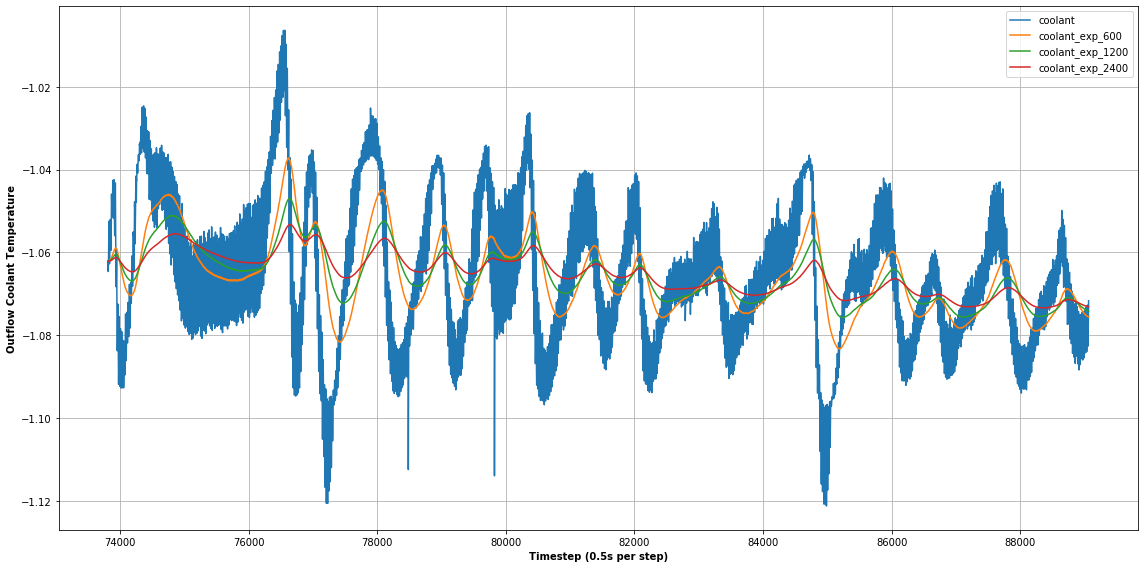

In [16]:
example_profile[chosen_cols].plot(figsize=(16,8))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Outflow Coolant Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

From the basic measured parameters, we want to be able to predict the temperatures at the rotor, stator yoke, stator tooth, and stator winding as part of the efforts in increasing Electric Vehicle (EV) efficiencies. It's not practical to be able to measure these in real time for commercialised vehicles, so being able to accurately predict these temperatures would be extremely valueble.

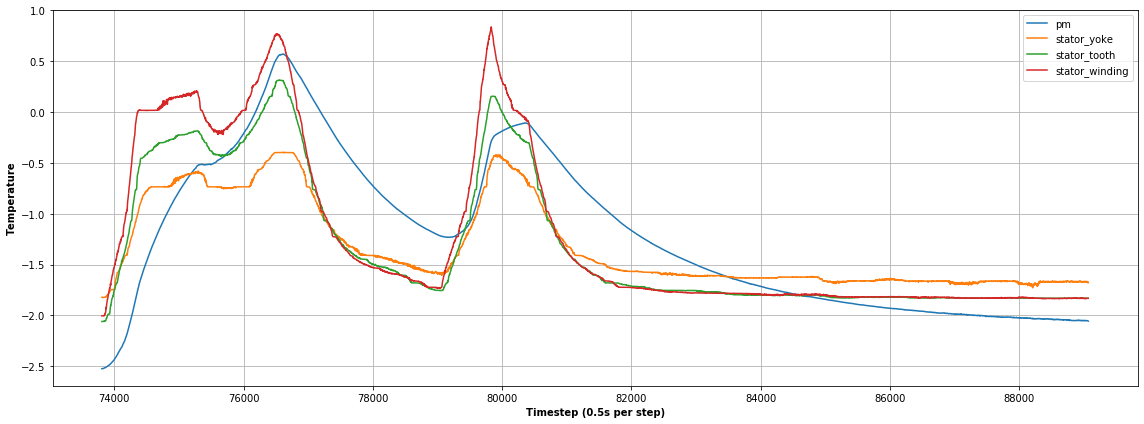

In [17]:
output_vars = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

example_profile[output_vars].plot(figsize=(16,6))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

A good thing is that for the example we've looked at, each of the four output dependent variables appear to be highly correlated. This should simply the process of making predictions for each of the variables given the operational motor data. When results are more correlated like this, it makes it easier for our multiple-output regression models to produce a good set of results from a unified model, rather than having to form individual models for each predicted output.

Let's see how these output variables look after applying applying an exponentially weighted average to each variable:

In [18]:
exp_ma = example_profile[output_vars].ewm(span=500).mean()

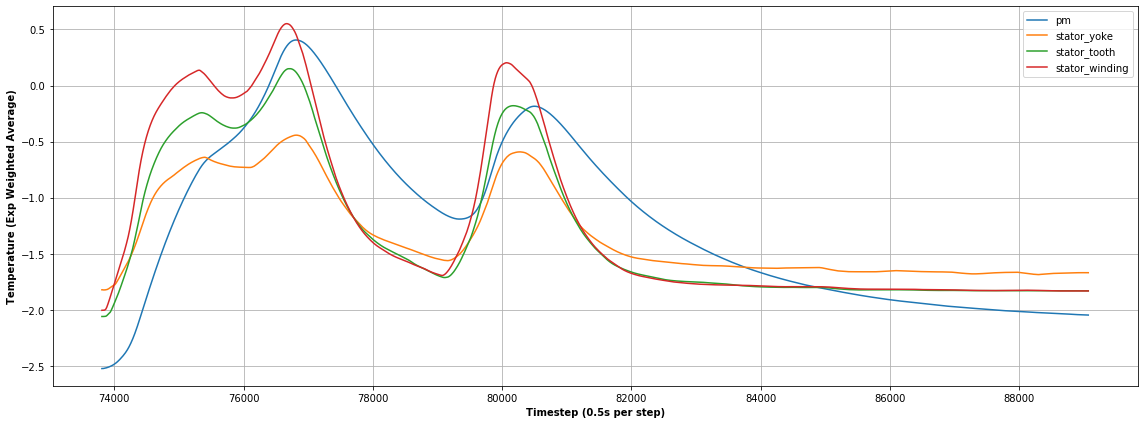

In [19]:
exp_ma.plot(figsize=(16,6))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Temperature (Exp Weighted Average)", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

Now let's assess the input features over time:

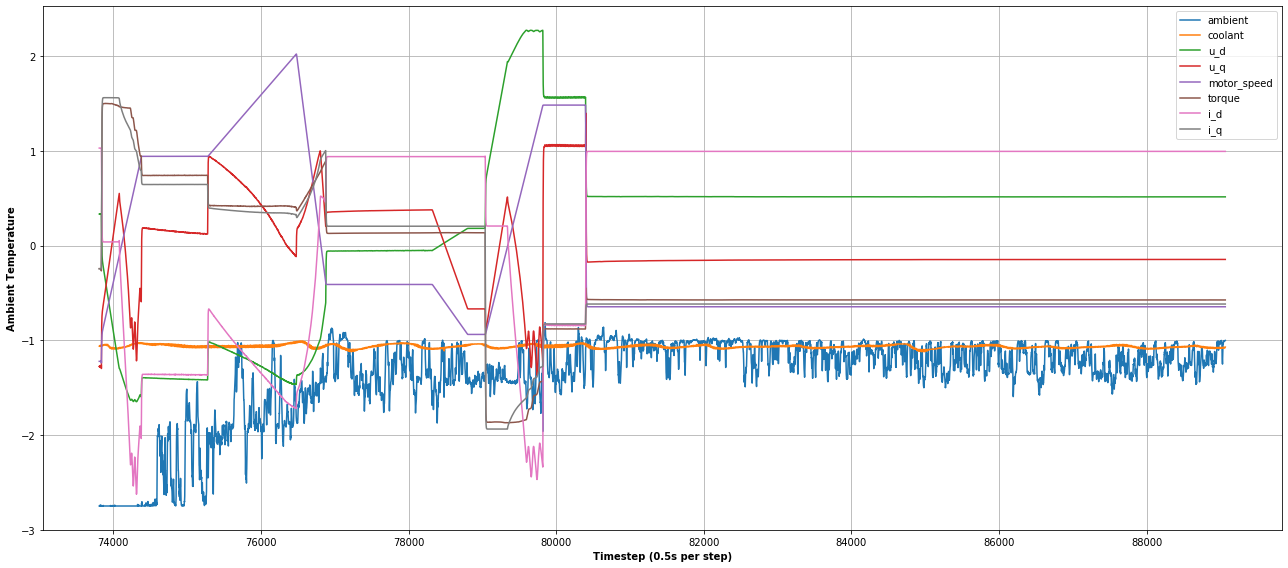

In [20]:
input_cols = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q']

example_profile[input_cols].plot(figsize=(18,8))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

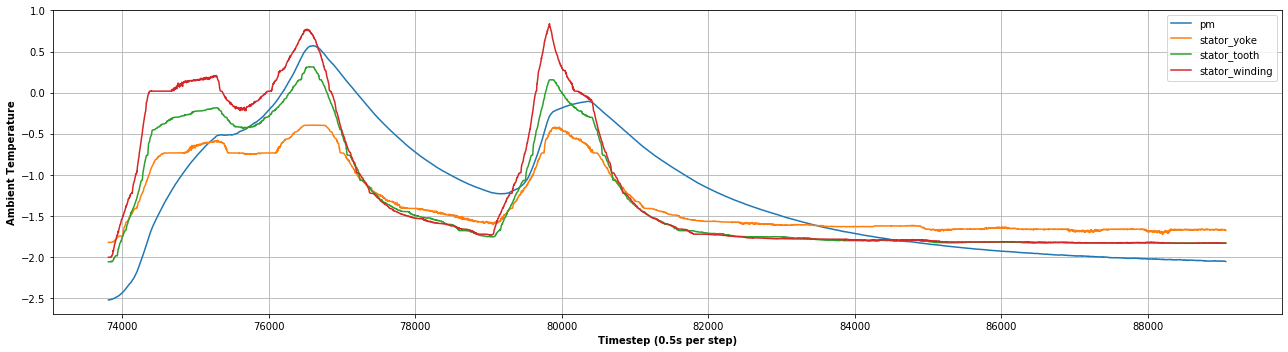

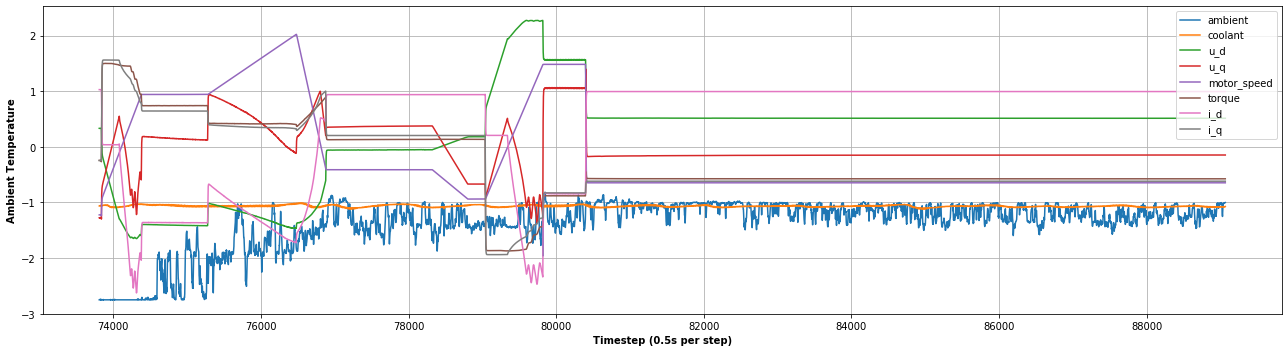

In [21]:
example_profile[output_vars].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

example_profile[input_cols].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

### 3.3 Correlation of our features

In [22]:
train_df_correlations = train_df.corr()

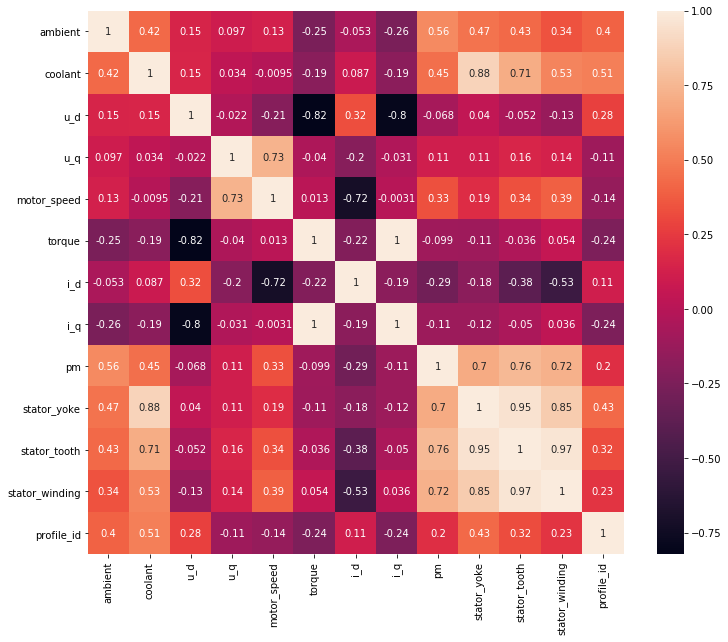

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(train_df_correlations, annot=True)
plt.show()

This is useful to understand the correlation some variables have relative to one-another. For instance, coolant looks like it is highly correlated to the stator yoke temperature. Since stator yoke temperature is also highly correlated to the other output variables, this could come in useful for making inferences of temperature given a set of input features.

A key thing to keep in mind is that a correlation matrix such as that above will only capture linear correlations. When analysing the previous plots, its clear that many of our variables are correlated, but these are more complex relationships that may not be captured well be the pearson correlation coefficient, which the matrix above is based on.

In [24]:
training_sample = train_df.sample(100000)

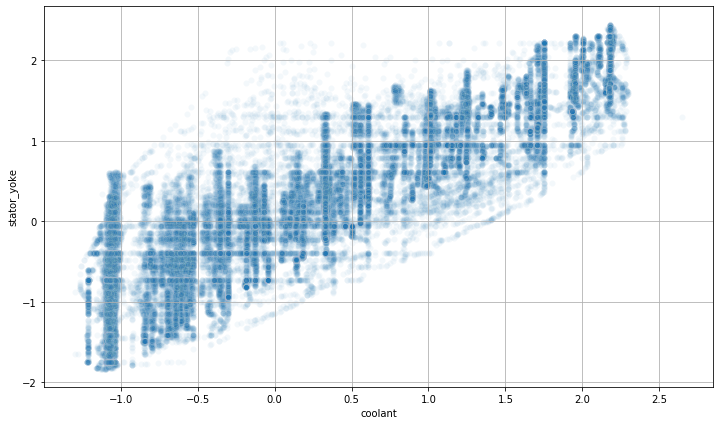

In [25]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='coolant', y='stator_yoke', data=training_sample, alpha=0.05)
plt.grid()
plt.show()

We have a nice correlation between coolant and one of the dependent outputs - stator yoke.

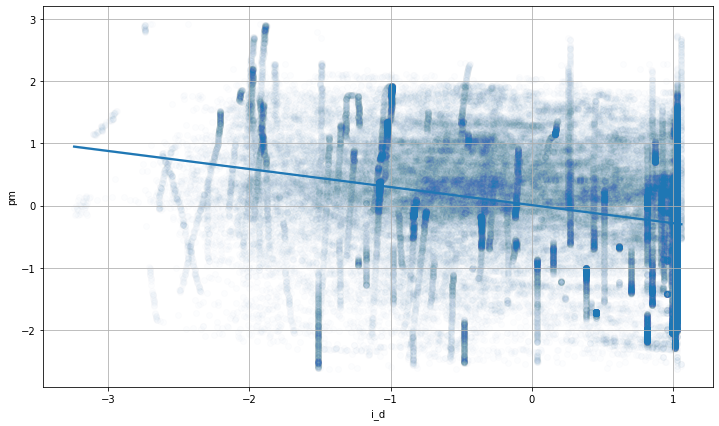

In [26]:
plt.figure(figsize=(12,7))
ax = sns.regplot(x="i_d", y="pm", data=training_sample, scatter_kws={'alpha':0.01})
plt.grid()
plt.show()

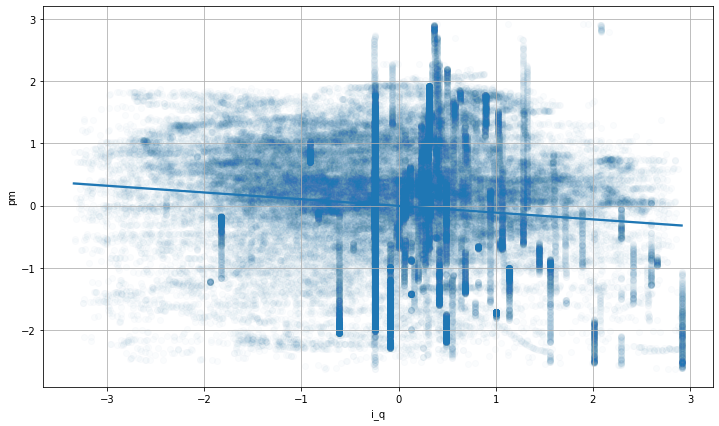

In [27]:
plt.figure(figsize=(12,7))
ax = sns.regplot(x="i_q", y="pm", data=training_sample, scatter_kws={'alpha':0.02})
plt.grid()
plt.show()

**Lets look at how the output variables are correlated to one-another:**

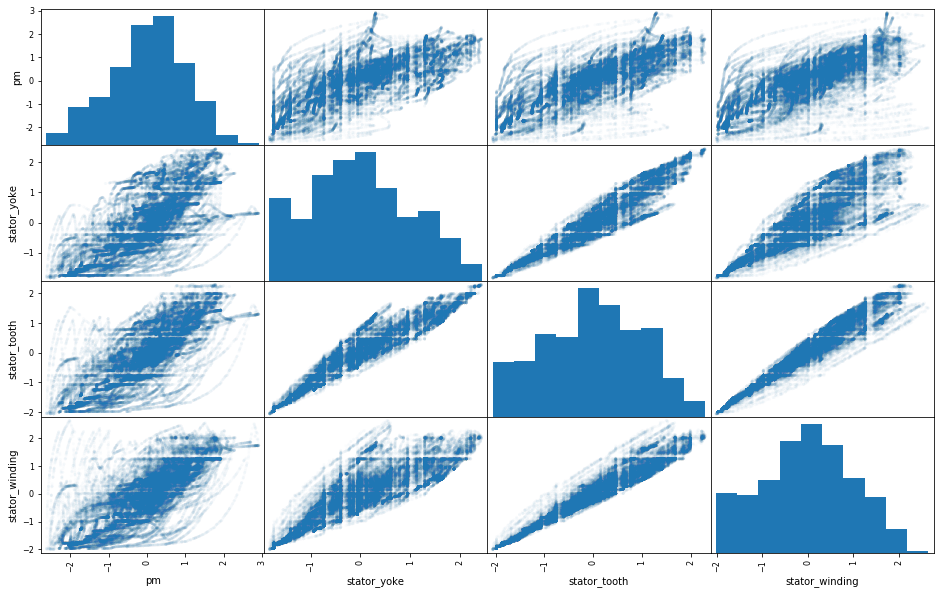

In [28]:
pd.plotting.scatter_matrix(training_sample[output_vars], figsize=(16, 10), alpha=0.02)
plt.show()

All of our output variables are highly correlated to one another, which makes sense; as the temperature of a given component tends to increase in the motor, so do all of the others on average. Again, as stated previously, this makes the multi-output regression problem slightly easier, since the different outputs we are trying to predict are all similar.

## 4. Baseline predictions on the test set using default off-the-shelf models

### 4.1 Basic Multiple-Output Linear Regression OLS 

Just so that the process of making a model and predicting on the dataset is familier, lets make some predictions on the test set using simple baseline models. We'll evaluate these models on the test set just to have an idea of what we should be aiming to beat.

In [38]:
y = train_df[output_vars]
X = train_df.drop(columns=output_vars + ['profile_id'])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

Lets train a normal multiple-output linear regression model on the data and see what results we obtain:

In [40]:
lin_reg = LinearRegression()

lr_scores = cross_val_score(lin_reg, X_train, y_train, 
                         scoring='neg_mean_squared_error', cv=10)

lr_rmse_scores = np.sqrt(-lr_scores)
print(f"Linear Regression RMSE: {lr_rmse_scores.mean():.5f} +/- {lr_rmse_scores.std():.5f}")

Linear Regression RMSE: 0.56903 +/- 0.00138


In [41]:
lin_reg.fit(X_train, y_train)
val_preds = lin_reg.predict(X_test)
print(f"Linear Regression RMSE on Validation Split: {np.sqrt(mean_squared_error(val_preds, y_test)):.4f}")

Linear Regression RMSE on Validation Split: 0.5695


### 4.2 Examining the predictions made by our baseline for an example Profile ID

Let's see what this model is like for reproducing a random profile from the dataset:

In [42]:
profile_4_idx = train_df[train_df['profile_id'] == 4].copy().index
profile_4_preds = lin_reg.predict(X.iloc[profile_4_idx])
profile_4_original = train_df.loc[profile_4_idx, output_vars]
profile_4_preds.shape, profile_4_original.shape

new_cols = [f"{x}_pred" for x in profile_4_original.columns]
profile_4_preds = pd.DataFrame(profile_4_preds)
profile_4_preds.columns = new_cols

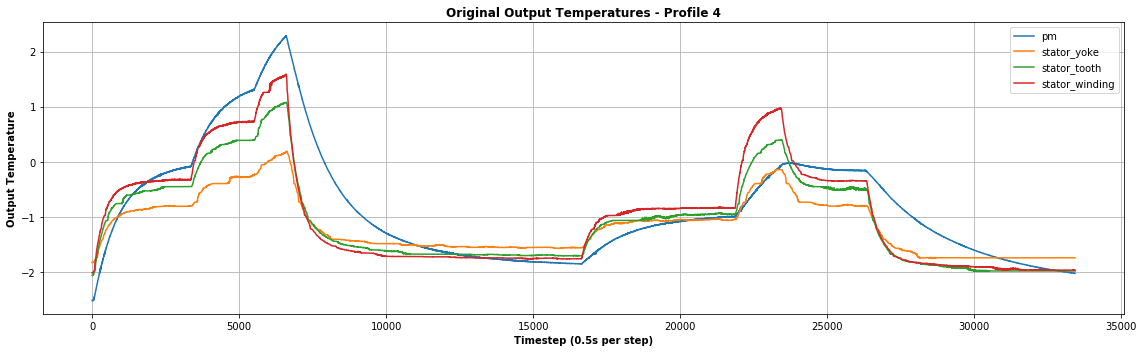

In [43]:
profile_4_original[output_vars].plot(figsize=(16,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Output Temperature", weight="bold")
plt.title("Original Output Temperatures - Profile 4", weight='bold')
plt.tight_layout()
plt.grid()
plt.show()

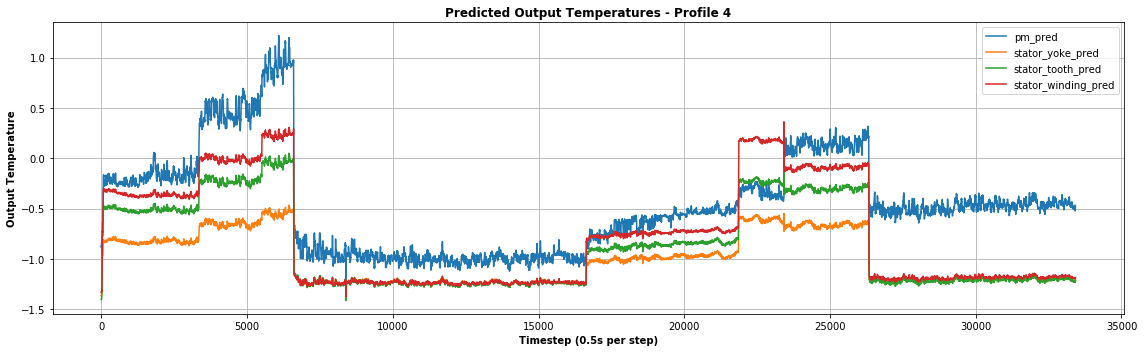

In [44]:
profile_4_preds.plot(figsize=(16,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Output Temperature", weight="bold")
plt.title("Predicted Output Temperatures - Profile 4", weight='bold')
plt.tight_layout()
plt.grid()
plt.show()

In [45]:
for column in profile_4_original.columns:
    mse = mean_squared_error(profile_4_original[column], profile_4_preds[column + '_pred'])
    rmse = np.sqrt(mse)
    print(f"RMSE for {column}: {rmse:.4f}")

RMSE for pm: 0.8439
RMSE for stator_yoke: 0.3523
RMSE for stator_tooth: 0.5105
RMSE for stator_winding: 0.5598


Not too bad straight off the bat, however this should not be relied on heavily since many of the data instances above could have been within the chosen training set, and therefore our linear regression model may have simply memorised many of those points above. For true generalisation evaluation we would need to test this model on a profile it has never seen before.

A good option for this would be to ensure our training and validation splits used to evaluate models contain unique profile IDs to one-another, so that the data we validate against is always new and unseen.

## 5. Feature Engineering and Improvements for better performance

### 5.1 Addition of new features:

From the provided electrical terms and measured data we have, we can combine these using various formulae to form new (and potentially insightful) features for our dataset. A key problem is that the data for this problem is already standardised, and unfortunately we have no access to the original dimensions or standardising parameters to reverse this process. Despite this, using the relationships defined below we can may still get some meaningful features from the standardised data, even if they are no longer mathematically sound products due to the standardised form its currently in.

**Voltage and current magnitudes**

We can work out the magnitudes of the voltage and current vectors by calculating the norm, as shown below:

$ v_{s} = \displaystyle\sqrt{v_{d}^{2} + v_{q}^{2}} $

$ i_{s} = \displaystyle\sqrt{i_{d}^{2} + i_{q}^{2}} $

Where $ v_{s} $ is the voltage magnitude, $ v_{d} $ is the d-component of the voltage, and $ v_{q} $ is the q-component of the voltage.

**Apparent Power**

Using these features, we can then determine electrical apparent power (magnitude of complex power), which is given by:

$ \vert S \vert = 1.5 \times v_{s} \times i_{s} $

**Effective Power**

Using the components of voltage and current we can also calculate effective power like so:

$ P = \big( v_{d} \times v_{q} \big) + \big( i_{d} \times i_{q} \big) $

**Additional Feature Combinations**

We'll also add some additional features, which represent the interaction between parameters of interest. This will include:

- Motor speed and current magnitude: $ \omega \times i_{s} $


- Motor speed and apparent power: $ \omega \times \vert S \vert $

In [29]:
def norm(row, col1, col2):
    return np.linalg.norm([row[col1], row[col2]])

In [30]:
def find_new_features(dataframe):
    """ Calculate new electrical features for our dataset """
    extra_df = dataframe.copy()
    
    extra_df['voltage_s'] = extra_df.apply(norm, args=('u_d', 'u_q'), axis=1)
    extra_df['current_s'] = extra_df.apply(norm, args=('i_d', 'i_q'), axis=1)
    extra_df['apparent_power'] = 1.5 * extra_df['voltage_s'] * extra_df['current_s']
    extra_df['effective_power'] = ((extra_df['u_d'] * extra_df['u_q']) +
                                (extra_df['i_d'] * extra_df['i_q']))
    extra_df['speed_current'] = extra_df['current_s'] * extra_df['motor_speed']
    extra_df['speed_power'] = extra_df['current_s'] * extra_df['apparent_power']
    
    return extra_df

In [31]:
train_df = find_new_features(train_df)
train_df.head()

ambient   coolant       u_d       u_q  motor_speed    torque  \
timestep                                                                  
0        -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182   
1        -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133   
2        -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431   
3        -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636   
4        -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701   

               i_d       i_q        pm  stator_yoke  stator_tooth  \
timestep                                                            
0         1.029572 -0.245860 -2.522071    -1.831422     -2.066143   
1         1.029509 -0.245832 -2.522418    -1.830969     -2.064859   
2         1.029448 -0.245818 -2.522673    -1.830400     -2.064073   
3         1.032845 -0.246955 -2.521639    -1.830333     -2.063137   
4         1.031807 -0.246610 -2.521900    -1.830498     -2.062795   

          stator_winding  profile_id  voltage_s  current_s  apparent_power  \
timestep                                                                     
0              -2.018033           4   1.338647   1.058521        2.125479   
1              -2.017631           4   1.338906   1.058453        2.125753   
2              -2.017343           4   1.343680   1.058390        2.133206   
3              -2.017632           4   1.343940   1.061958        2.140812   
4              -2.018145           4   1.345541   1.060869        2.141163   

          effective_power  speed_current  speed_power  
timestep                                               
0               -0.678744      -1.293966     2.249864  
1               -0.680888      -1.293884     2.250009  
2               -0.686266      -1.293805     2.257764  
3               -0.689494      -1.298170     2.273453  
4               -0.691267      -1.296836     2.271492

In [32]:
example_profile = train_df.loc[train_df['profile_id'] == EXAMPLE_ID].copy()

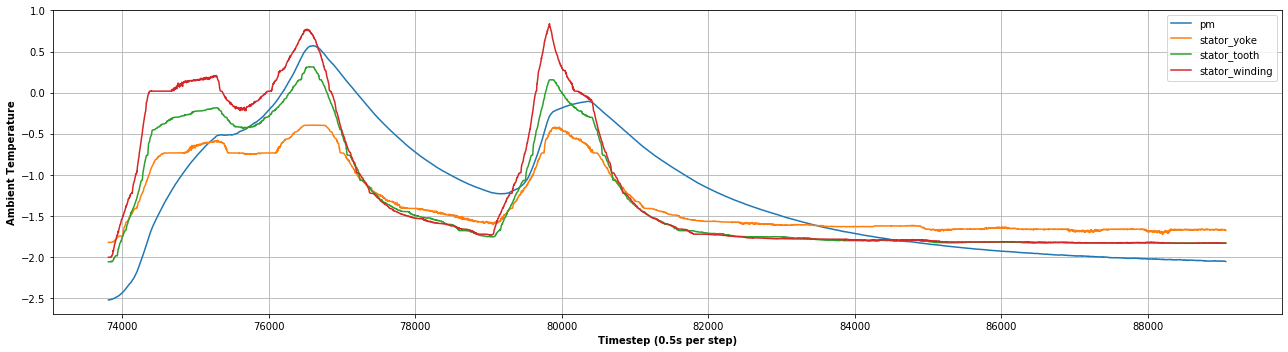

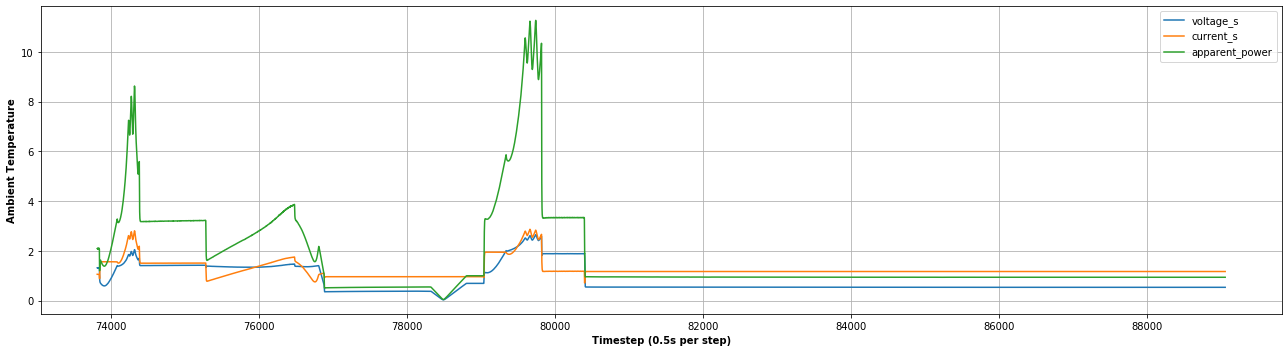

In [33]:
example_profile[output_vars].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

example_profile[['voltage_s', 'current_s', 'apparent_power']].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

We can see that apparent power actually correlates well to the output variables - at least for this example profile ID.

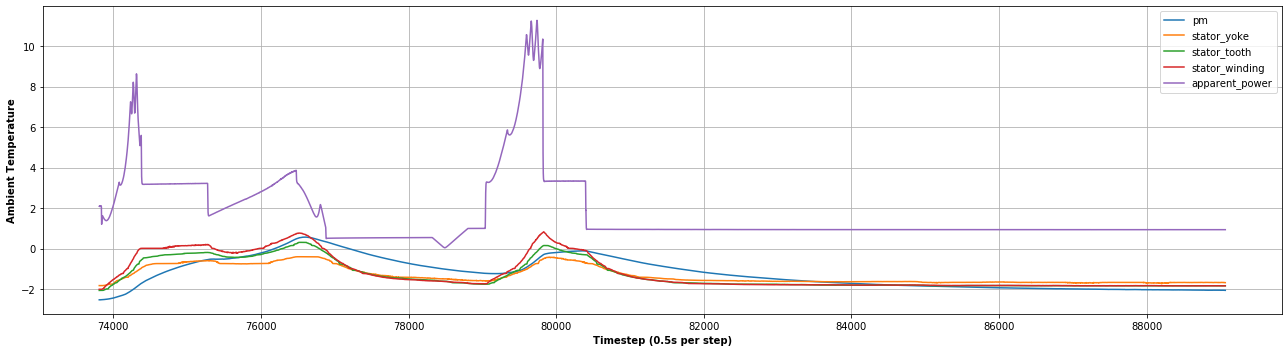

In [34]:
example_profile[output_vars + ['apparent_power']].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

Lets now standardise our apparent power variable with zero mean and a unit standard deviation, which should fit it to the output variable data better:

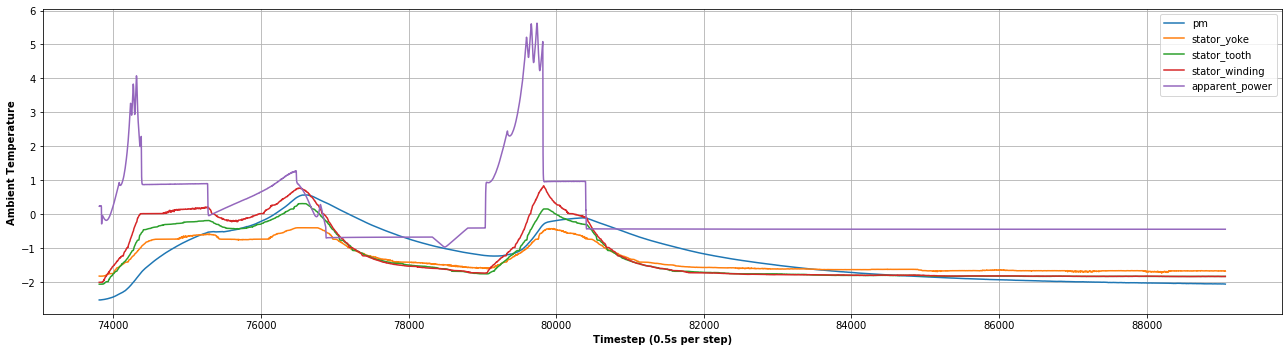

In [35]:
example_profile['apparent_power'] = ((example_profile['apparent_power'] - 
                                     example_profile['apparent_power'].mean()) /
                                     example_profile['apparent_power'].std())

example_profile[output_vars + ['apparent_power']].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

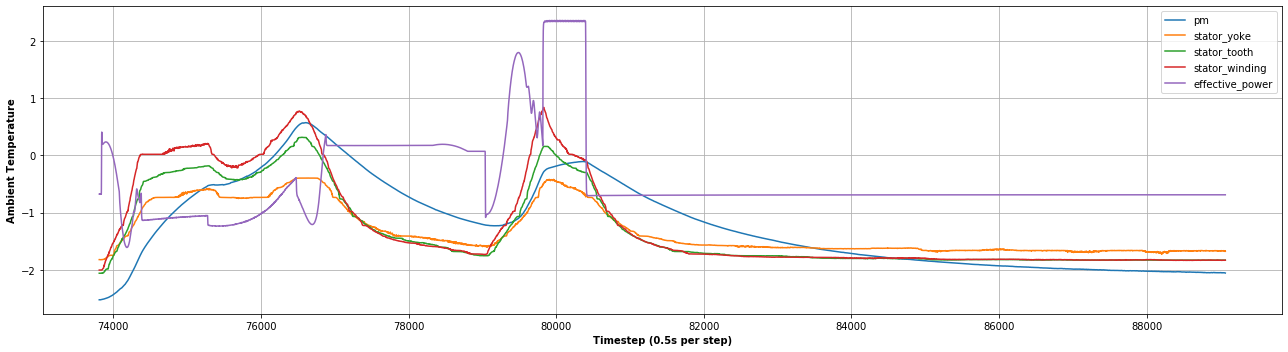

In [36]:
example_profile[output_vars + ['effective_power']].plot(figsize=(18,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Ambient Temperature", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

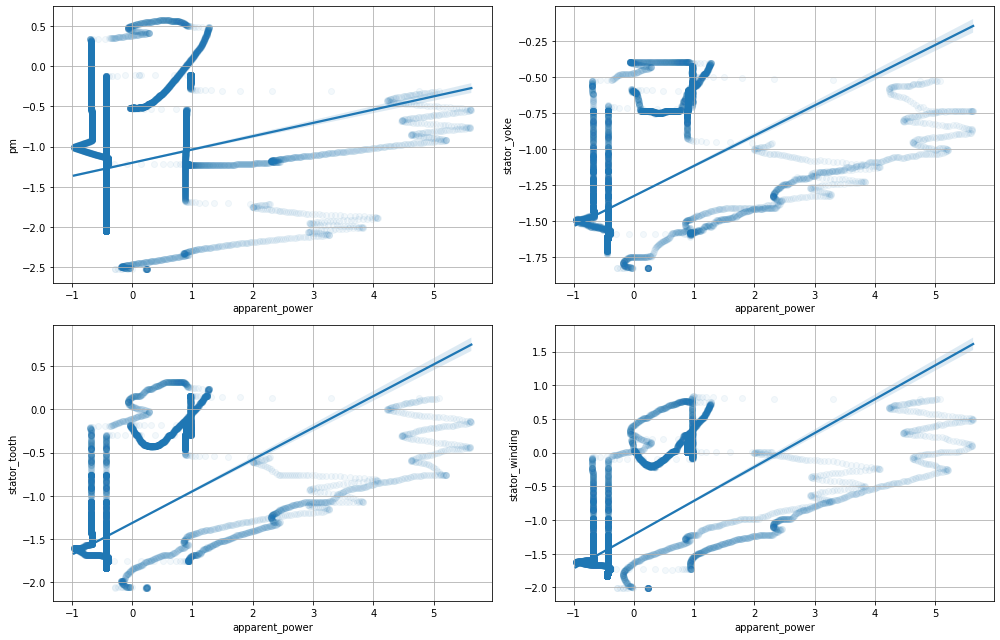

In [37]:
plot_var = 'apparent_power'
alpha = 0.05

plt.figure(figsize=(14,9))

plt.subplot(221)
ax = sns.regplot(x=plot_var, y="pm", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(222)
ax = sns.regplot(x=plot_var, y="stator_yoke", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(223)
ax = sns.regplot(x=plot_var, y="stator_tooth", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(224)
ax = sns.regplot(x=plot_var, y="stator_winding", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()
plt.tight_layout()
plt.show()

### 5.2 Introduction of exponentially weighted averages

Let's try applying a low pass filter (exponentially weighted averages are the equivalent of doing this) to our data and seeing how this impacts the relationship our input features have with the output features.

Let's try with the apparent power variable and see how different variations of it correlate to the output variables when we apply averaging functions with different spans:

In [38]:
# choose a range of spans to experiment with
spans = [600, 1200, 2400, 4800]

chosen_col = 'apparent_power'

for span in spans:
    new_col = f"{chosen_col}_exp_{span}"
    example_exp_ma = example_profile.ewm(span=span, adjust=False).mean()
    example_profile[new_col] = example_exp_ma[chosen_col].copy()
    
chosen_cols = [x for x in example_profile.columns.values if x.startswith(chosen_col)]

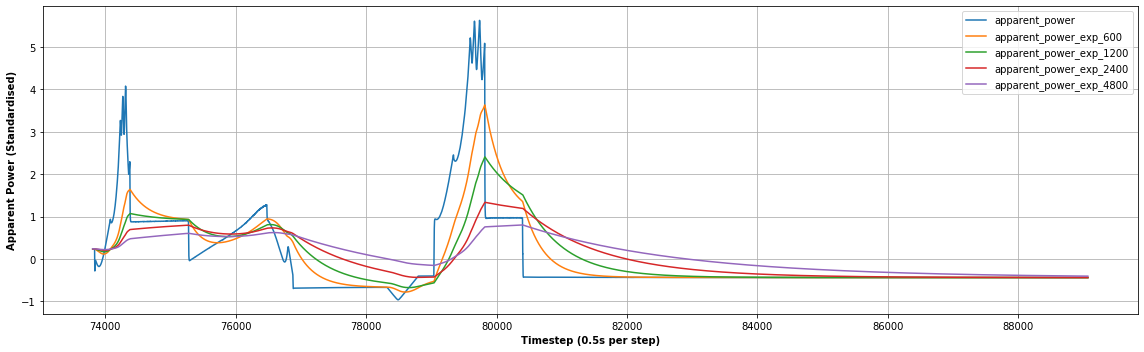

In [39]:
example_profile[chosen_cols].plot(figsize=(16,5))
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Apparent Power (Standardised)", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

In [40]:
cols = output_vars + chosen_cols
color_dict = {}

for column in cols:
    if column == 'apparent_power':
        color_dict[column] = 'black'
    elif column.startswith('apparent_power_exp'):
        color_dict[column] = 'tab:blue'
    else:
        color_dict[column] = 'tab:red'

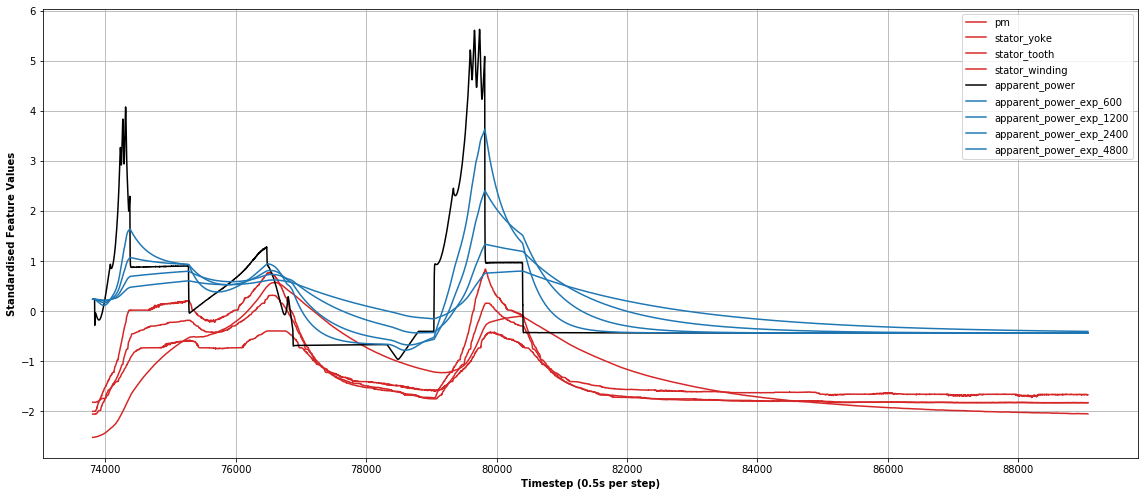

In [41]:
example_profile[output_vars + chosen_cols].plot(figsize=(16,7), 
                                                color=[color_dict.get(x, 'black') for x in cols])
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Standardised Feature Values", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

Its quite interesting how well the apparent power feature correlates to our output temperatures when we apply a low-pass filter (exponentially weighted average) to it. This certainly works well for this specific profile ID. It could be worth exploring others to make sure it also correlates well to those.

In all cases, it seems like the apparent power feature was well worth introducing into our dataset.

In [42]:
# translate apparent power variables by 1.5
example_profile[chosen_cols[1:]] = example_profile[chosen_cols[1:]] - 1.5

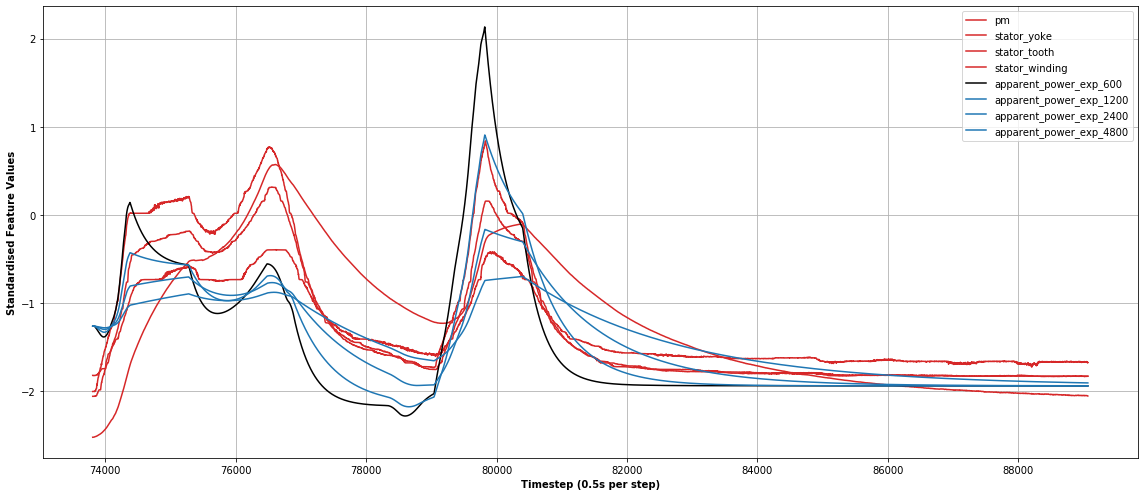

In [43]:
example_profile[output_vars + chosen_cols[1:]].plot(figsize=(16,7), 
                                                color=[color_dict.get(x, '#333333') for x in cols])
plt.xlabel("Timestep (0.5s per step)", weight="bold")
plt.ylabel("Standardised Feature Values", weight="bold")
plt.tight_layout()
plt.grid()
plt.show()

Through a simple translation downwards, we can almost fit the apparent power plots onto the various temperature plots!

It will be worth fitting a new model with these variables and seeing how this improves performance relative to the baseline models!

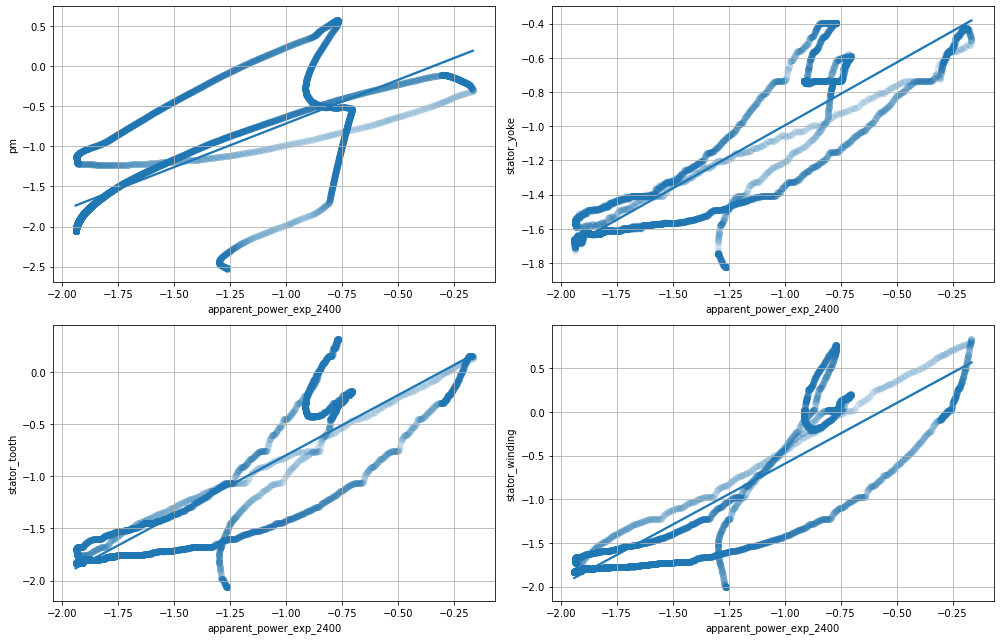

In [44]:
plot_var = 'apparent_power_exp_2400'
alpha = 0.05

plt.figure(figsize=(14,9))

plt.subplot(221)
ax = sns.regplot(x=plot_var, y="pm", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(222)
ax = sns.regplot(x=plot_var, y="stator_yoke", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(223)
ax = sns.regplot(x=plot_var, y="stator_tooth", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()

plt.subplot(224)
ax = sns.regplot(x=plot_var, y="stator_winding", data=example_profile, scatter_kws={'alpha':alpha})
plt.grid()
plt.tight_layout()
plt.show()

In [45]:
corr_matrix = example_profile.corr()
corr_matrix['stator_yoke'].sort_values(ascending=False)

stator_yoke                1.000000
stator_tooth               0.994689
stator_winding             0.979051
apparent_power_exp_2400    0.910743
apparent_power_exp_4800    0.877578
apparent_power_exp_1200    0.873203
motor_speed                0.869178
pm                         0.837778
speed_current              0.837285
apparent_power_exp_600     0.778965
voltage_s                  0.686590
u_q                        0.575719
apparent_power             0.494767
i_q                        0.382552
torque                     0.368605
speed_power                0.351779
coolant                    0.281685
effective_power            0.238293
current_s                  0.219542
ambient                   -0.383443
u_d                       -0.421367
i_d                       -0.771736
profile_id                      NaN
Name: stator_yoke, dtype: float64

The relationships are not quite linear and are more complex, but they're definitely much better than before we added any features.

### 5.3 Extending our data with the exponentially weighted average features 

Let's add these exponentially weighted averages to our training data and see how they perform when used to train a model. We'll automate this process through the definition of a class to do our pre-processing.

In [46]:
class PMSMDataProcessor(BaseEstimator, TransformerMixin):
    """ PMSM data processor and loader """
    
    def __init__(self, add_exp_terms=True, spans=[600, 1200, 2400, 4800],
                 output_vars=['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']):
        self.add_exp_terms = add_exp_terms
        self.spans = [600, 1200, 2400, 4800]
        self.output_vars = output_vars
        self.training_cols = []
        
        
    def fit(self, X, y=None):      
        return self
                
    
    def transform(self, X):
        """ Create new features from our given data """
        
        extra_df = self._find_new_features(X)
        
        # update training cols
        self._update_train_cols(extra_df)
        
        # if selected add additional exponential terms
        if self.add_exp_terms:
            extra_df = self._find_exp_terms(extra_df).copy()
            
            # update training cols again to reflect new additions
            self._update_train_cols(extra_df)
            
        return extra_df
        
        
    def _find_norm(self, row, col1, col2):
        return np.linalg.norm([row[col1], row[col2]])
    
    
    def _update_train_cols(self, X):
        """ Compile list of base columns used for training """
        self.training_cols = [x for x in X if x != 'profile_id' 
                              and x not in self.output_vars]
    
    
    def _find_new_features(self, dataframe):
        """ Calculate new electrical features for our dataset """
        
        extra_cols = dataframe.copy()
        
        extra_cols['voltage_s'] = extra_cols.apply(self._find_norm, 
                                                   args=('u_d', 'u_q'), axis=1)
        extra_cols['current_s'] = extra_cols.apply(self._find_norm, 
                                                   args=('i_d', 'i_q'), axis=1)
        
        extra_cols['apparent_power'] = 1.5 * extra_cols['voltage_s'] * extra_cols['current_s']
        extra_cols['effective_power'] = ((extra_cols['u_d'] * extra_cols['u_q']) +
                                         (extra_cols['i_d'] * extra_cols['i_q']))
        
        extra_cols['speed_current'] = extra_cols['current_s'] * extra_cols['motor_speed']
        extra_cols['speed_power'] = extra_cols['current_s'] * extra_cols['apparent_power']
    
        return extra_cols
    
    
    def _find_exp_terms(self, dataframe):
        """ Add exponential terms to all features, using the class spans """
        
        extended_df = dataframe.copy()
        
        # add new columns to each feature for each span
        for span in self.spans:
            exp_ma_df = dataframe.ewm(span=span, adjust=False).mean()
            for column in self.training_cols:
                new_col = f"{column}_exp_{span}"
                extended_df[new_col] = exp_ma_df[column].copy()
                
        return extended_df

**Process data from scratch again:**

In [47]:
data_preprocessor = PMSMDataProcessor()

train_df_extra = data_preprocessor.fit_transform(train_df)
test_df_extra = data_preprocessor.transform(test_df)

y = train_df_extra[data_preprocessor.output_vars].copy()
X = train_df_extra.drop(columns=data_preprocessor.output_vars)

X.shape, y.shape, test_df_extra.shape

((846368, 71), (846368, 4), (76423, 70))

Although we dont want to use it as training data, we need to keep track of our profile IDs within the training set so that we can ensure appropriate splits of data between training and validation splits.

In [48]:
# select profile id's as groups to split our folds on
groups = X.loc[:, 'profile_id'].copy()
X.drop('profile_id', axis=1, inplace=True)

### 5.4 Standardise all features of our processed data

Although our data was already standardised originally, since we've introduced new features we should standardise again to ensure the new columns are consistent relative to the original features.

We'll need to remove the profile IDs, standardise our features, and then add it in as a column again:

In [49]:
std_scaler = StandardScaler()
X_std = pd.DataFrame()
X_std[X.columns] = pd.DataFrame(std_scaler.fit_transform(X))
X_std['profile_id'] = groups.values
test_std = std_scaler.transform(test_df_extra)

X_std.head(3)

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.853838 -1.127481  0.276182 -1.302293    -1.210656 -0.208486  1.015618   
1 -0.873390 -1.126078  0.277917 -1.302122    -1.210657 -0.207438  1.015554   
2 -0.885280 -1.125744  0.281033 -1.306259    -1.210655 -0.207736  1.015492   

        i_q  voltage_s  current_s  ...  torque_exp_4800  i_d_exp_4800  \
0 -0.204768  -0.002205  -0.365393  ...        -0.373373      1.911797   
1 -0.204741  -0.001627  -0.365508  ...        -0.373372      1.911797   
2 -0.204726   0.009017  -0.365614  ...        -0.373371      1.911797   

   i_q_exp_4800  voltage_s_exp_4800  current_s_exp_4800  \
0     -0.362029           -0.002501           -0.870159   
1     -0.362029           -0.002500           -0.870159   
2     -0.362029           -0.002492           -0.870159   

   apparent_power_exp_4800  effective_power_exp_4800  speed_current_exp_4800  \
0                -0.639940                 -1.012621               -1.712389   
1                -0.639940                 -1.012623               -1.712389   
2                -0.639936                 -1.012630               -1.712389   

   speed_power_exp_4800  profile_id  
0             -0.957336           4  
1             -0.957336           4  
2             -0.957334           4  

[3 rows x 71 columns]

## 6. Improved splitting of data - ensuring unique profile IDs between splits

For a better and true appreciation of the generalisation performance of our model we need to ensure that the training, validation and test splits all contain different profile IDs. This ensures that the data is unseen from what we've trained our models on.

Due to the requirement to know the profile_id of the training data, we need to keep track of the profile IDs corresponding to the training instances, which is stored in the profiles variable.

We have two options for grouped kfolds. We can either split without shuffling, using GroupKFold, or Shuffle our groups to get different subsets of groups each time (but still no like-groups in both splits, just as we need).

We'll use the shuffling option, since we want to be able to mix up the splits of profile_id we get between different folds, in order to help assess the true generalisation of our models.

In [50]:
grouped_kfold = GroupShuffleSplit(n_splits=6)
grouped_kfold.get_n_splits(X_std, y, groups)

6

To illustrate how this works, this kfold iterator returns the following splits:

In [51]:
for train_index, test_index in grouped_kfold.split(X_std, y, groups):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    train_inputs, val_inputs = X_std.iloc[train_index], X_std.iloc[test_index]
    train_outputs, val_outputs = y.iloc[train_index], y.iloc[test_index]
    
    profiles_train = train_inputs['profile_id'].value_counts().index.values
    profiles_test = val_inputs['profile_id'].value_counts().index.values
    
    print(f"Profile IDs in Training set: \n{profiles_train}\n")
    print(f"Profile IDs in Test set: \n{profiles_test}\n")

TRAIN: (686315,) TEST: (160053,)
Profile IDs in Training set: 
[20  6 65 66 27  4 56 79 44 70 30 80 68 76 48 29 81 45 63 69 10 77 60 57
 75 49 50 55 43 11 59 64 47]

Profile IDs in Test set: 
[58 53 74 36 72 67 54 78 46]

TRAIN: (637621,) TEST: (208747,)
Profile IDs in Training set: 
[ 6 66 27  4 58 56 44 70 30 74 68 36 76 48 29 81 45 63 69 72 10 77 60 57
 67 50 54 78 43 11 59 64 46]

Profile IDs in Test set: 
[20 65 53 79 80 75 49 55 47]

TRAIN: (654942,) TEST: (191426,)
Profile IDs in Training set: 
[20 65 66 27  4 58 56 53 79 70 74 68 76 48 81 45 63 69 72 10 77 60 57 49
 50 55 54 43 11 59 64 46 47]

Profile IDs in Test set: 
[ 6 44 30 80 36 29 75 67 78]

TRAIN: (661712,) TEST: (184656,)
Profile IDs in Training set: 
[20  6 65 66 27 58 56 70 30 80 74 68 36 76 48 29 81 45 63 69 10 77 75 67
 49 50 54 78 43 11 59 46 47]

Profile IDs in Test set: 
[ 4 53 79 44 72 60 57 55 64]

TRAIN: (702320,) TEST: (144048,)
Profile IDs in Training set: 
[20  6 65 66 27  4 58 53 79 44 80 74 68 36 76 48 

This is good, we have a nice random subset of profile IDs for each fold, and in each case, the profile IDs within the training split are not present within the validation split. This ensures a much better evaluation of performance when testing our models.

## 7. Testing the baseline performance with improved splits and additional features

Lets test this using our OLS linear regression model, and repeat it 10 times so that we can find the average performance across multiple attempts of cross-validation:

In [69]:
lr_rmse_scores = []
mean_rmse_scores = []

lr_reg = LinearRegression()

# times to repeat the cross validation
repeats = 10

for i in tqdm(range(repeats)):
    lr_scores = cross_val_score(lr_reg, X_std.drop('profile_id', axis=1), y, groups=groups,
                                scoring='neg_mean_squared_error', cv=grouped_kfold)
    rmse_scores = np.sqrt(-lr_scores)
    lr_rmse_scores.append(rmse_scores)
    mean_rmse_scores.append(rmse_scores.mean())

lr_rmse_scores = np.array(lr_rmse_scores)
mean_rmse_scores = np.array(mean_rmse_scores)

print(f"Linear Regression OLS RMSE: {mean_rmse_scores.mean():.5f} +/- {mean_rmse_scores.std():.5f}")

100%|██████████| 10/10 [01:02<00:00,  6.27s/it]

Linear Regression OLS RMSE: 0.29905 +/- 0.00959


These results are much better than the original baseline models, which highlights the improvement that adding our extra features has resulted in. We could likely improve by filtering the output of our linear regression model, in order to smooth the output noise.

What's interesting about this result is we might have expected performance to have dropped, due to the improvement in how we split our data. Clearly, the addition of more insightful features has helped overcome this and increase performance considerably. 

## 8. Exploring a range of default models using Cross-Validation

It will be heplful to explore a range of different models and test their performance against one-another accordingly, so that we can choose the best and then perform further fine-tuning.

Since the training set is very large computation time can be a problem, especially if we are using techniques like cross-validation and grid-search. To counteract this, we will initially make a subsample of training data to make our comparisons on, which should greatly speed up this process. As above, we'll ensure we split training and validation so that profile ids are unique across splits:

In [52]:
def multi_model_grouped_cross_validation(clf_tuple_list, X, y, groups, K_folds=6, random_seed=0, subsample=False,
                                 score_type='neg_mean_squared_error', subsample_prop=0.1):
    """ Find grouped cross validation scores, and print and return results """
    
    model_names, model_scores = [], []
    
    # if selected, only use a small portion of data for speed
    if subsample:
        X, _, y, _ = train_test_split(X, y, training_size=subsample_prop, random_seed=random_seed)
    
    for name, model in clf_tuple_list:
        grouped_kfold = GroupShuffleSplit(n_splits=K_folds)
        cross_val_results = cross_val_score(model, X, y, groups=groups, 
                                            cv=grouped_kfold, scoring=score_type, n_jobs=-1)
        model_names.append(name)
        rmse_scores = np.sqrt(-cross_val_results)
        model_scores.append(rmse_scores)
        print("{0:<40} {1:.5f} +/- {2:.5f}".format(name, rmse_scores.mean(), rmse_scores.std()))
        
    return model_names, model_scores


def boxplot_comparison(model_names, model_scores, figsize=(14, 10), score_type="RMSE",
                       title="K-Folds Cross-Validation Comparisons"):
    """ Boxplot comparison of a range of models using Seaborn and matplotlib """
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=18)
    ax = fig.add_subplot(111)
    sns.boxplot(x=model_names, y=model_scores)
    ax.set_xticklabels(model_names)
    ax.set_xlabel("Model", fontsize=16) 
    ax.set_ylabel("Model Score ({})".format(score_type), fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    plt.show()
    return

Due to significant computation time and our large dataset, we'll only conduct this on a small sub-sample of the total data:

In [53]:
X_trg_sub, _, y_trg_sub, _ = train_test_split(X_std, y, stratify=groups, test_size=0.99, random_state=12)

# extract our training profiles from the training data prior to fitment
trg_profiles = X_trg_sub.loc[:, 'profile_id'].values
X_trg_sub = X_trg_sub.drop('profile_id', axis=1)

X_trg_sub.shape, y_trg_sub.shape

((8463, 70), (8463, 4))

K-Folds Cross-Validation Results on training set: 
------------------------------------------------------------
Linear Regressor                         0.31588 +/- 0.02393
Ridge Regressor                          0.28795 +/- 0.03828
LASSO Regressor                          0.39647 +/- 0.03888
ElasticNet                               0.29190 +/- 0.02315
Support Vector Regressor                 0.31715 +/- 0.03051
Extra Trees Regressor                    0.35413 +/- 0.02792
Random Forest Regressor                  0.36096 +/- 0.01279
Multi-layer Perception                   0.33082 +/- 0.02554
CPU times: user 295 ms, sys: 235 ms, total: 530 ms
Wall time: 26.8 s


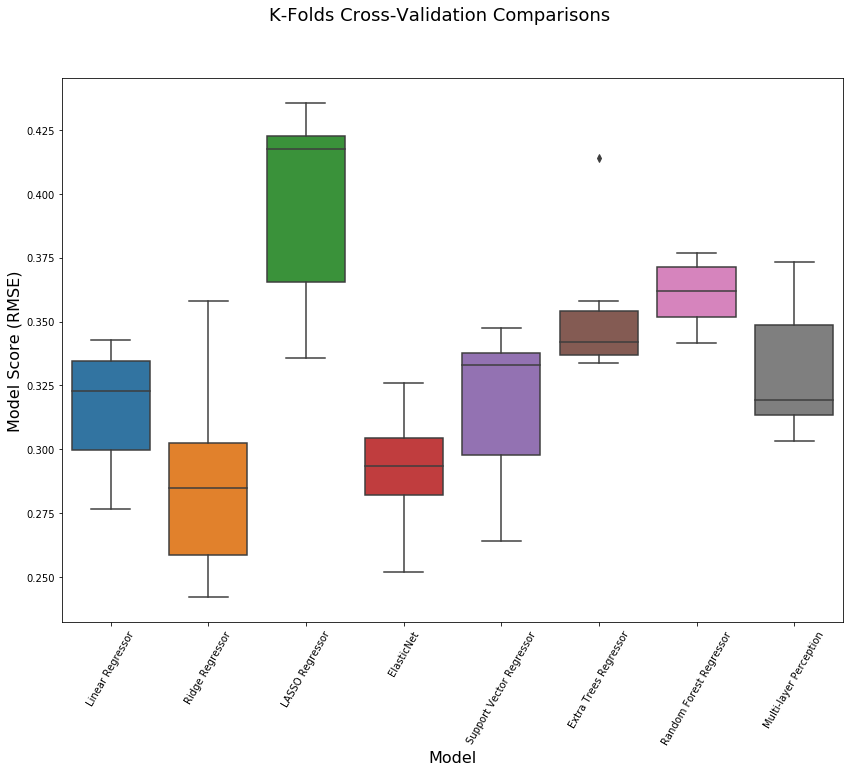

In [72]:
# list of classifiers to compare
clf_list = [("Linear Regressor", LinearRegression()),
            ("Ridge Regressor", Ridge(alpha=250)),
            ("LASSO Regressor", Lasso(alpha=0.1)),
            ("ElasticNet", ElasticNet(alpha=0.01, l1_ratio=0.1)),
            ("Support Vector Regressor", MultiOutputRegressor(LinearSVR())),
            ("Extra Trees Regressor", ExtraTreesRegressor(n_estimators=10, bootstrap=True, max_depth=60, 
                                                          n_jobs=-1, min_samples_leaf=3, min_samples_split=5)),
            ("Random Forest Regressor", RandomForestRegressor(n_estimators=10, bootstrap=True, max_depth=60, 
                                                              n_jobs=-1, min_samples_leaf=3, min_samples_split=5)),
            ("Multi-layer Perception", MLPRegressor())]

# obtain names and scores for each cross-validation, and print / plot results
print("K-Folds Cross-Validation Results on training set: \n{}".format('-'*60))
%time model_names, model_scores = multi_model_grouped_cross_validation(clf_list, X_trg_sub, y_trg_sub, trg_profiles)
boxplot_comparison(model_names, model_scores)

Interestingly, our linear regression models appear to be the best in this case. This has also been the case in the previous results we obtained, which suggests a simple, yet very effective solution to the problem of predicting real-time temperatures in our motors is using a linear regression OLS model.

Our tree based methods took a long time to train above, so it could be worth reducing the size of our dataset further when exploring the optimisation of these methods.

## 9. Exploring and tuning our individual regression models:

Lets explore linear regression and regularisation a bit more, since it is the best performing model from all of those above.

### 9.1 Exploration of a Ridge regressor and the alpha hyper-parameter:

Since our ridge regressor was good, but not quite as good as standard unregularised linear regression, it could be worth exploring a range of hyper-parameters to see whether we can improve performance accordingly:

In [73]:
alpha_values = [0, 0.01, 0.1, 0.5, 1.0, 1.5, 3, 10, 20, 50, 100, 
                200, 250, 500, 750, 1000, 2000, 3000, 4000, 5000]

ridge_rmse_scores = []
mean_ridge_rmse_scores = []

for alpha in tqdm(alpha_values):
    ridge_reg = Ridge(alpha=alpha, fit_intercept=True)
    ridge_scores = cross_val_score(ridge_reg, X, y, groups=groups,
                                   scoring='neg_mean_squared_error', cv=grouped_kfold)
    rmse_scores = np.sqrt(-ridge_scores)
    ridge_rmse_scores.append(rmse_scores)
    mean_ridge_rmse_scores.append(rmse_scores.mean())

ridge_rmse_scores = np.array(ridge_rmse_scores)
mean_ridge_rmse_scores = np.array(mean_ridge_rmse_scores)

print(f"Ridge RMSE: {mean_ridge_rmse_scores.mean():.5f} +/- {mean_ridge_rmse_scores.std():.5f}")

# calculate standard deviation to annotate on our plot
ridge_rmse_scores_std = ridge_rmse_scores.std(axis=1)

100%|██████████| 20/20 [00:52<00:00,  2.63s/it]

Ridge RMSE: 0.28441 +/- 0.00867


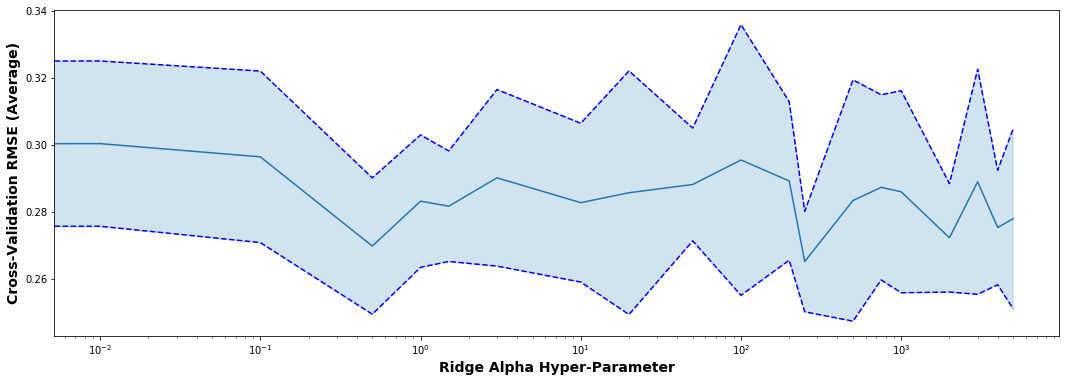

In [74]:
# plot mean and standard deviation of cross-val scores
plt.figure(figsize=(18,6))
sns.lineplot(x=alpha_values, y=mean_ridge_rmse_scores)
plt.fill_between(alpha_values, mean_ridge_rmse_scores - ridge_rmse_scores_std, 
                 mean_ridge_rmse_scores + ridge_rmse_scores_std, 
                 color='tab:blue', alpha=0.2)
plt.semilogx(alpha_values, mean_ridge_rmse_scores + ridge_rmse_scores_std, 'b--')
plt.semilogx(alpha_values, mean_ridge_rmse_scores - ridge_rmse_scores_std, 'b--')
plt.ylabel("Cross-Validation RMSE (Average)", weight='bold', size=14)
plt.xlabel("Ridge Alpha Hyper-Parameter", weight='bold', size=14)
plt.show()

### 9.2 Exploring LASSO regression in a similar way:

LASSO tends to perform automatic feature reduction by setting the coefficient of low-importance features to zero during training. The extend to which this occurs is related to the hyper-parameter values we select at model creation. We'll explore a range of these similarly to how we did with Ridge regression above:

In [75]:
# range of alpha values between 0 and 1
alpha_values = np.logspace(-4, 1, 20)

lasso_rmse_scores = []
mean_lasso_rmse_scores = []

for alpha in tqdm(alpha_values):
    lasso_reg = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000, tol=0.5)
    lasso_scores = cross_val_score(lasso_reg, X, y, groups=groups,
                                   scoring='neg_mean_squared_error', cv=grouped_kfold)
    rmse_scores = np.sqrt(-lasso_scores)
    lasso_rmse_scores.append(rmse_scores)
    mean_lasso_rmse_scores.append(rmse_scores.mean())

lasso_rmse_scores = np.array(lasso_rmse_scores)
mean_lasso_rmse_scores = np.array(mean_lasso_rmse_scores)

print(f"LASSO RMSE: {mean_lasso_rmse_scores.mean():.5f} +/- {mean_lasso_rmse_scores.std():.5f}")

100%|██████████| 20/20 [02:21<00:00,  7.05s/it]

LASSO RMSE: 0.55523 +/- 0.27135


It seems our models struggle to converge if not given enough iterations. If our performance is good enough, it may be worth increasing this accordingly in order to maximise the potential performance of our LASSO models.

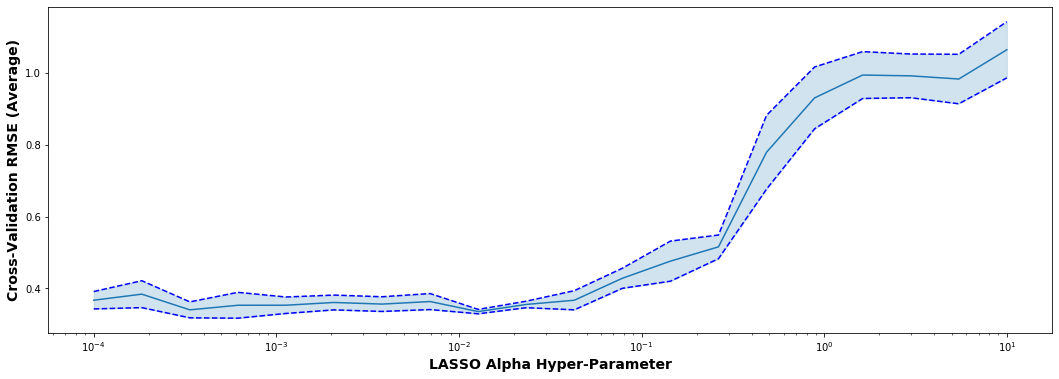

In [76]:
# calculate standard deviation to annotate on our plot
lasso_rmse_scores_std = lasso_rmse_scores.std(axis=1)

# plot mean and standard deviation of cross-val scores
plt.figure(figsize=(18,6))
sns.lineplot(x=alpha_values, y=mean_lasso_rmse_scores)
plt.fill_between(alpha_values, mean_lasso_rmse_scores - lasso_rmse_scores_std, 
                 mean_lasso_rmse_scores + lasso_rmse_scores_std, 
                 color='tab:blue', alpha=0.2)
plt.semilogx(alpha_values, mean_lasso_rmse_scores + lasso_rmse_scores_std, 'b--')
plt.semilogx(alpha_values, mean_lasso_rmse_scores - lasso_rmse_scores_std, 'b--')
plt.ylabel("Cross-Validation RMSE (Average)", weight='bold', size=14)
plt.xlabel("LASSO Alpha Hyper-Parameter", weight='bold', size=14)
plt.show()

### 9.3 Combining the effects of L1 and L2 regularisation together using Elastic Net:

For this we'll explore a range of alpha and l1_ratio parameters to see whether elastic net has potential or not:

In [77]:
# range of alpha values and l1 ratios for exploring
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
l1_ratios = np.arange(0.0, 1.1, 0.1)

results_tuples = []
en_rmse_scores = []
mean_en_rmse_scores = []

for alpha in tqdm(alpha_values):
    for l1 in l1_ratios:
        
        en_reg = ElasticNet(alpha=alpha, l1_ratio=l1, tol=0.5,
                            fit_intercept=True, max_iter=1000)
        en_scores = cross_val_score(en_reg, X, y, groups=groups,
                                    scoring='neg_mean_squared_error', cv=grouped_kfold)
        rmse_scores = np.sqrt(-en_scores)
        en_rmse_scores.append(rmse_scores)
        mean_en_rmse_scores.append(rmse_scores.mean())
        
        results_tuples.append((alpha, l1, rmse_scores.mean(), rmse_scores.std()))

en_rmse_scores = np.array(en_rmse_scores)
mean_en_rmse_scores = np.array(mean_en_rmse_scores)

print(f"Elastic Net RMSE: {mean_en_rmse_scores.mean():.5f} +/- {mean_en_rmse_scores.std():.5f}")

100%|██████████| 7/7 [08:37<00:00, 73.92s/it]

Elastic Net RMSE: 0.59342 +/- 0.28855


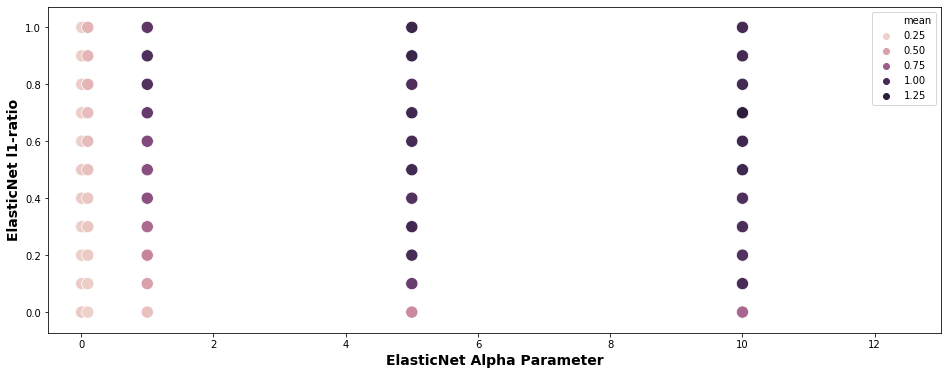

In [78]:
# form dataframe from the results
elasnet_results = pd.DataFrame(results_tuples)
elasnet_results.columns = ['alpha', 'l1_ratio', 'mean', 'std']

# plot results according to hyper-parameters and mean RMSE
plt.figure(figsize=(16,6))
sns.scatterplot(x='alpha', y='l1_ratio', hue='mean', 
                data=elasnet_results, s=150)
plt.xlabel('ElasticNet Alpha Parameter', weight='bold', size=14)
plt.ylabel('ElasticNet l1-ratio', weight='bold', size=14)
plt.legend(loc='best')
plt.xlim(-0.5, 13.0)
plt.show()

It seems that regularisation really isn't helping our linear model perform any better on our dataset; The basic linear regression model without any regularisation tends to perform better on our temperature prediction task when compared to the regularised methods. This can be seen in the plot above, whereby the points towards the lower right of the plot (those more representing normal linear regression with no regularisation) perform much better. This suggests that we're not actually fitting our data enough, and therefore performing regularisation (preventing over-fitting) may actually be harmful rather than good. We could consider adding further features to produce a more complex model, but in this case the results will suffice.

### 9.4 Investigating performance of bootstrapped linear regression ensemble:

In [79]:
lr_bag_reg = BaggingRegressor(LinearRegression(), n_estimators=5, bootstrap=True)

lr_bag_rmse_scores = []
mean_lr_bag_rmse_scores = []

# times to repeat the cross validation
repeats = 2

for i in tqdm(range(repeats)):
    lr_bag_scores = cross_val_score(lr_bag_reg, X, y, groups=groups,
                                scoring='neg_mean_squared_error', cv=grouped_kfold)
    rmse_scores = np.sqrt(-lr_bag_scores)
    lr_bag_rmse_scores.append(rmse_scores)
    mean_lr_bag_rmse_scores.append(rmse_scores.mean())

lr_bag_rmse_scores = np.array(lr_bag_rmse_scores)
mean_lr_bag_rmse_scores = np.array(mean_lr_bag_rmse_scores)

print(f"Lin Reg Bagging RMSE: {mean_lr_bag_rmse_scores.mean():.5f} +/- {mean_lr_bag_rmse_scores.std():.5f}")

100%|██████████| 2/2 [01:32<00:00, 46.26s/it]

Lin Reg Bagging RMSE: 0.29010 +/- 0.00427


### 9.5 Exploration of tree based models:

The performance of our random forest and extra tree regressors were not actually that bad. With refinement, these could become good models to include within a final ensemble, and therefore its worth trying to optimise the performance if we can.

In order to do this, we'll take an even smaller stratified sample of training instances based on profile ID (due to higher time complexity with these methods), followed by unique grouping between training / validation of profile IDs, just like we did above. This will allow us to experiment and fine-tune on a much smaller subsample, which still has the benefit of having different profile IDs between our training and validation splits.

In [80]:
X_trg_sub, _, y_trg_sub, _ = train_test_split(X_std, y, stratify=groups, test_size=0.99, random_state=12)
trg_profiles = X_trg_sub.loc[:, 'profile_id'].values

print(f"Number of profile IDs within sample: {X_trg_sub['profile_id'].value_counts().shape[0]}\n")

# drop profile ID before training
X_trg_sub = X_trg_sub.drop('profile_id', axis=1)

print(f"Shapes of data: X = {X_trg_sub.shape}, y = {y_trg_sub.shape}")

sample_group_kfold = GroupShuffleSplit(n_splits=6)

Number of profile IDs within sample: 42

Shapes of data: X = (8463, 70), y = (8463, 4)


Good - our sample still retains instances from all 42 profile IDs after our stratified sampling technique. We can now perform grouped K-Folds on this in a similar way to above.

#### Exploration of Extra Trees Hyper-Parameters

Below we'll define a range of parameters to use with grid search for finding optimal hyper-parameters for our Extra Trees Regressor. Note - we'll not bother using the n_estimators parameter, since we know a larger number of estimators helps to reduce overfitting, so for the final model we'll use a large number of n_estimators. By using this during grid search we'll just increase the search time considerably for relatively little insight.

In [81]:
et_param_grid = {'n_estimators' : [10], 'max_depth' : [5, 10, 20, 60], 
                 'min_samples_split' : [2, 5, 10, 20], 'min_samples_leaf' : [1, 3, 5, 10], 
                 'n_jobs': [-1], 'bootstrap' : [True]}

et_reg = ExtraTreesRegressor()
et_grid_search = GridSearchCV(et_reg, et_param_grid, cv=sample_group_kfold, scoring='neg_mean_squared_error')

In [82]:
# fit to our grid search with grouped kfold
%time et_grid_search.fit(X_trg_sub, y_trg_sub, groups=trg_profiles)

CPU times: user 20.4 s, sys: 3.34 s, total: 23.7 s
Wall time: 1min 59s


GridSearchCV(cv=GroupShuffleSplit(n_splits=6, random_state=None, test_size=None,
         train_size=None),
             error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           mi...
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, w

In [85]:
# display best parameters found during grid search
best_et_params = et_grid_search.best_params_
best_et_params

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 10,
 'n_jobs': -1}

In [87]:
# change best params n_estimators to a higher a more appropriate value
best_et_params['n_estimators'] = 600
best_et_params

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 600,
 'n_jobs': -1}

Best parameters found were: 
{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_jobs': -1}

Let's perform cross-validation again using this model and the optimal hyper-parameters, along with more estimators:

In [88]:
et_reg = ExtraTreesRegressor(**best_et_params)

et_scores = cross_val_score(et_reg, X_trg_sub, y_trg_sub, groups=trg_profiles, 
                            scoring='neg_mean_squared_error', cv=sample_group_kfold)

et_rmse_scores = np.sqrt(-et_scores)
print(f"Extra Trees Reg RMSE: {et_rmse_scores.mean():.5f} +/- {et_rmse_scores.std():.5f}")

Extra Trees Reg RMSE: 0.32231 +/- 0.04317


The performance of this model is not bad now! If we trained this on all of the training set, I expect this performance would be improved even further, especially when considering this model has only been trained on less than 1% of the total training set!

If we perform the same with Random Forest, the optimal parameters found are similar, although performance is slightly less than that found with the Extra Trees Regressor; Clearly the extra bias provided by Extra Trees lets it perform better to our data than that with a Random Forest.

Either of these tree based models will be ideal to use in a final ensemble model for our regression problem. Extra Trees is preferable, since its much faster to train, and better performing in this case.

**Exploring the performance of a Gradient Boosting Regressor:**

In [89]:
gb_reg = MultiOutputRegressor(GradientBoostingRegressor())

gb_scores = cross_val_score(gb_reg, X_trg_sub, y_trg_sub, groups=trg_profiles, 
                            scoring='neg_mean_squared_error', cv=sample_group_kfold)

gb_rmse_scores = np.sqrt(-gb_scores)
print(f"Gradient Boosting Reg RMSE: {gb_rmse_scores.mean():.5f} +/- {gb_rmse_scores.std():.5f}")

Gradient Boosting Reg RMSE: 0.29923 +/- 0.01953


Clearly our gradient boosting regressor has high potential here, and could likely be trained to have better performance than our linear regression OLS model. The problem with this method however is the extremely long training time on the entire dataset, which could become problematic.

If we performed hyper-parameter optimisation on this, I have no doubt that it would be the highest performing model so far on our data.

### 9.6 Production of a stacking ensemble to combine the predictions of multiple models:

A good strategy is to combine the results of multiple models together, which often results in a better overall performance than either of the standalone models produce. This assumes that each model chosen is relatively good in terms of performance, and the more diversity we have between each model used in the ensemble, the better the chance of our performance being better for a given task.

Just to illustrate this concept, and produce a reasonable model, lets combine the benefits of a tree based model, Extra Trees Regressor, along with our multiple-output Linear Regression OLS mode (with no regularisation).

In [91]:
regressors = [('Bagged Linear Reg', BaggingRegressor(LinearRegression(), n_estimators=20, bootstrap=True)), 
              ('Extra Trees Reg', ExtraTreesRegressor(**best_et_params))]

In [92]:
ensemble_reg = MultiOutputRegressor(VotingRegressor(estimators=regressors, n_jobs=-1))

ensemble_scores = cross_val_score(ensemble_reg, X_trg_sub, y_trg_sub, groups=trg_profiles, 
                            scoring='neg_mean_squared_error', cv=sample_group_kfold)

ensemble_rmse_scores = np.sqrt(-ensemble_scores)
print(f"Ensemble Reg RMSE: {ensemble_rmse_scores.mean():.5f} +/- {ensemble_rmse_scores.std():.5f}")

Ensemble Reg RMSE: 0.26291 +/- 0.03077


As expected, our ensemble is actually better performing than either model alone! This should suffice for a final submission and evaluation on the test set.

## 10. Producing our models and making predictions on the final test set

In [54]:
data_preprocessor = PMSMDataProcessor()

train_df_extra = data_preprocessor.fit_transform(train_df)
test_df_extra = data_preprocessor.transform(test_df)

y = train_df_extra[data_preprocessor.output_vars].copy()
X = train_df_extra.drop(columns=data_preprocessor.output_vars)

# select profile id's as groups to split our folds on
groups = X.loc[:, 'profile_id'].copy()
X.drop('profile_id', axis=1, inplace=True)

X.shape, y.shape, test_df_extra.shape

((846368, 70), (846368, 4), (76423, 70))

In [55]:
std_scaler = StandardScaler()
X_std = pd.DataFrame()
X_std[X.columns] = pd.DataFrame(std_scaler.fit_transform(X))
test_std = std_scaler.transform(test_df_extra)

In [56]:
bag_lr_reg = BaggingRegressor(LinearRegression(), n_estimators=20, bootstrap=True)
%time bag_lr_reg.fit(X_std, y)

CPU times: user 1min 12s, sys: 3.27 s, total: 1min 15s
Wall time: 32.5 s


BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=20, n_jobs=None, oob_score=False,
                 random_state=None, verbose=0, warm_start=False)

In [58]:
et_opt_params = {'n_estimators' : 600, 'bootstrap': True, 'max_depth': 20, 
                 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_jobs': -1}

In [62]:
regressors = [('Bagged Linear Reg', BaggingRegressor(LinearRegression(), n_estimators=20, bootstrap=True)), 
              ('Extra Trees Reg', ExtraTreesRegressor(**et_opt_params))]

# create our final ensemble model
ensemble_reg = MultiOutputRegressor(VotingRegressor(estimators=regressors))

In [63]:
%time ensemble_reg.fit(X_std, y)

CPU times: user 5min 30s, sys: 54.5 s, total: 6min 24s
Wall time: 1h 41min 45s


MultiOutputRegressor(estimator=VotingRegressor(estimators=[('Bagged Linear Reg',
                                                            BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                                                                             fit_intercept=True,
                                                                                                             n_jobs=None,
                                                                                                             normalize=False),
                                                                             bootstrap=True,
                                                                             bootstrap_features=False,
                                                                             max_features=1.0,
                                                                             max_samples=1.0,
                                  

In [64]:
test_preds = ensemble_reg.predict(test_std)

In [66]:
# import test results and compare
test_results = pd.read_csv('test_solutions.csv')

In [67]:
print(f"Final Ensemble RMSE on Test Set: {np.sqrt(mean_squared_error(test_preds, test_results)):.5f}")

Final Ensemble RMSE on Test Set: 0.30288


## Closing Remarks

So there we have it - a final prediction on our test set, which was completely unseen by the trained models due to the unique Profile IDs assigned to the test at the very beginning of this notebook. Our performance was pretty strong, especially when considering the relative simplicity of the models that we used in our final product.

We could definitely improve this model further, which could be done by one or more of the following strategies:

- Production of a larger ensemble with more diversity.

- Use of better models, such as gradient boosting regressors to produce our final model. This wasn't included within this notebook due to the significant training time of a gradient boosting model on the huge dataset provided. However, the basic concepts remain the same and this could easily be added into the above analysis.

- Use of a neural network implementation with a better capacity to learn the complex relationships within our data.

- Better exploitation of time-series within our data, which could be done by the use of models such as RNN LSTMs or CNNs to learn time-dependent patterns within our data. It's expected that if we did this well, it would result in the best overall performance when compared to any other classical model implementation. The downside of this is the inference time could be greater, and the training time could be significant due to model complexity.

I hope you enjoyed this notebook - many thanks for reading!